Found 68 hazy images.
Found 5 ground truth images.
Total data pairs: 68
Loaded pre-trained model.
Train Epoch: 0 [0/68 (0%)]	Loss: 0.002059
Train Epoch: 1 [0/68 (0%)]	Loss: 0.002965
Train Epoch: 2 [0/68 (0%)]	Loss: 0.001532
Train Epoch: 3 [0/68 (0%)]	Loss: 0.002000
Train Epoch: 4 [0/68 (0%)]	Loss: 0.001347
Train Epoch: 5 [0/68 (0%)]	Loss: 0.001047
Train Epoch: 6 [0/68 (0%)]	Loss: 0.002444
Train Epoch: 7 [0/68 (0%)]	Loss: 0.002301
Train Epoch: 8 [0/68 (0%)]	Loss: 0.000668
Train Epoch: 9 [0/68 (0%)]	Loss: 0.002216
losses: [0.002059173071756959, 0.01426821481436491, 0.0035654886160045862, 0.0032598457764834166, 0.003031261498108506, 0.010926689021289349, 0.0053182183764874935, 0.003100752830505371, 0.005417918786406517, 0.0024705363903194666, 0.005191472824662924, 0.005630362778902054, 0.004121371079236269, 0.0030659453477710485, 0.002477191621437669, 0.0026976291555911303, 0.0024967039935290813, 0.002964831655845046, 0.003460751147940755, 0.001956053078174591, 0.00152176758274436, 0.0057

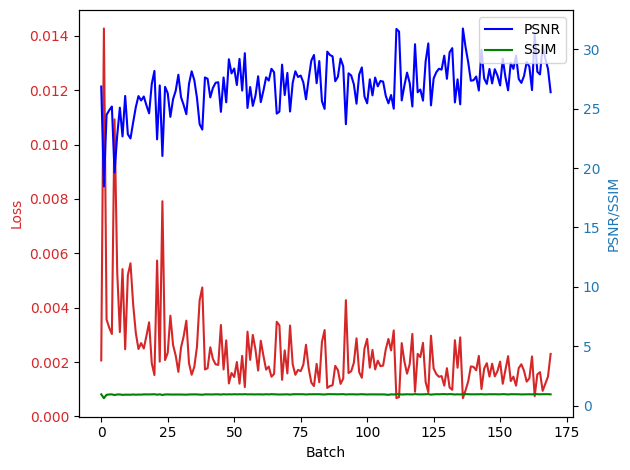

In [2]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from math import exp
import math
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
    
# Define helper functions (e.g., for data loading and preprocessing)
class HazyDataset(Dataset):
    def __init__(self, hazy_dir, gt_dir, transform=None):
        self.hazy_dir = hazy_dir
        self.gt_dir = gt_dir
        self.transform = transform

        # Get list of hazy and ground truth images
        self.hazy_images = sorted(os.listdir(hazy_dir))
        self.gt_images = sorted(os.listdir(gt_dir))
        
        # Create a list of all hazy images and their corresponding ground truth
        self.data = []
        for gt_img in self.gt_images:
            gt_base_name = os.path.splitext(gt_img)[0].replace('_GT', '')
            matching_hazy_imgs = [img for img in self.hazy_images if gt_base_name in img]
            for hazy_img in matching_hazy_imgs:
                self.data.append((hazy_img, gt_img))

        print(f"Found {len(self.hazy_images)} hazy images.")
        print(f"Found {len(self.gt_images)} ground truth images.")
        print(f"Total data pairs: {len(self.data)}")

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        hazy_img_name, gt_img_name = self.data[idx]

        hazy_image_path = os.path.join(self.hazy_dir, hazy_img_name)
        gt_image_path = os.path.join(self.gt_dir, gt_img_name)

        hazy_image = Image.open(hazy_image_path).convert('RGB')
        gt_image = Image.open(gt_image_path).convert('RGB')

        if self.transform:
            hazy_image = self.transform(hazy_image)
            gt_image = self.transform(gt_image)

        return hazy_image, gt_image

# Define the default convolutional layer
def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size, padding=(kernel_size // 2), bias=bias)

# Define the pixel attention layer
class PALayer(nn.Module):
    def __init__(self, channel):
        super(PALayer, self).__init__()
        self.pa = nn.Sequential(
            nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // 8, 1, 1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.pa(x)
        return x * y

# Define the channel attention layer
class CALayer(nn.Module):
    def __init__(self, channel):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.ca = nn.Sequential(
            nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // 8, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.ca(y)
        return x * y

# Define the basic block
class Block(nn.Module):
    def __init__(self, conv, dim, kernel_size):
        super(Block, self).__init__()
        self.conv1 = conv(dim, dim, kernel_size, bias=True)
        self.act1 = nn.ReLU(inplace=True)
        self.conv2 = conv(dim, dim, kernel_size, bias=True)
        self.calayer = CALayer(dim)
        self.palayer = PALayer(dim)

    def forward(self, x):
        res = self.act1(self.conv1(x))
        res = res + x
        res = self.conv2(res)
        res = self.calayer(res)
        res = self.palayer(res)
        res = res + x
        return res

# Define the group of blocks
class Group(nn.Module):
    def __init__(self, conv, dim, kernel_size, blocks):
        super(Group, self).__init__()
        modules = [Block(conv, dim, kernel_size) for _ in range(blocks)]
        modules.append(conv(dim, dim, kernel_size))
        self.gp = nn.Sequential(*modules)

    def forward(self, x):
        res = self.gp(x)
        res = res + x
        return res

# Define the FFA network with additional convolutional layers
class FFA(nn.Module):
    def __init__(self, gps, blocks, conv=default_conv):
        super(FFA, self).__init__()
        self.gps = gps
        self.dim = 64
        kernel_size = 3
        pre_process = [
            conv(3, self.dim, kernel_size),
            nn.ReLU(inplace=True),
            conv(self.dim, self.dim, kernel_size),  # Added conv layer
            nn.ReLU(inplace=True),
            conv(self.dim, self.dim, kernel_size),  # Added conv layer
            nn.ReLU(inplace=True),
            conv(self.dim, self.dim, kernel_size)   # Added conv layer
        ]
        self.g1 = Group(conv, self.dim, kernel_size=kernel_size, blocks=blocks)
        self.g2 = Group(conv, self.dim, kernel_size=kernel_size, blocks=blocks)
        self.g3 = Group(conv, self.dim, kernel_size=kernel_size, blocks=blocks)
        self.ca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(self.dim * 3, self.dim // 16, 1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.dim // 16, self.dim * 3, 1, padding=0, bias=True),
            nn.Sigmoid()
        )
        self.palayer = PALayer(self.dim)

        post_process = [
            conv(self.dim, self.dim, kernel_size),
            conv(self.dim, 3, kernel_size)
        ]

        self.pre = nn.Sequential(*pre_process)
        self.post = nn.Sequential(*post_process)

    def forward(self, x1):
        x = self.pre(x1)
        res1 = self.g1(x)
        res2 = self.g2(res1)
        res3 = self.g3(res2)

        w = self.ca(torch.cat([res1, res2, res3], dim=1))
        w = w.view(-1, self.dim, 3, 1, 1)
        out = (w[:, :, 0, :, :] * res1) + (w[:, :, 1, :, :] * res2) + (w[:, :, 2, :, :] * res3)
        out = self.palayer(out)
        x = self.palayer(out)
        x = self.post(out)
        return x + x1

def load_pretrained_model(model, model_path, device):
    state_dict = torch.load(model_path, map_location=device)
    
    # Filter out unnecessary keys and handle missing keys
    model_state_dict = model.state_dict()
    filtered_state_dict = {}
    for key, value in state_dict.items():
        if key in model_state_dict:
            filtered_state_dict[key] = value
        else:
            print(f"Skipping key {key} from pre-trained model")

    # Check for missing keys
    missing_keys = set(model_state_dict.keys()) - set(filtered_state_dict.keys())
    if missing_keys:
        print(f"Missing keys in pre-trained model: {missing_keys}")

    model.load_state_dict(filtered_state_dict, strict=False)
    print("Loaded pre-trained model.")

# Define helper functions (e.g., for data loading and preprocessing)
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2
    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

def ssim(img1, img2, window_size=11, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    return _ssim(img1, img2, window, window_size, channel, size_average)

def train(model, device, train_loader, criterion, optimizer, num_epochs, log_interval=50):
    model.train()
    losses = []
    psnrs = []
    ssims = []
    max_psnr = 0
    max_ssim = 0

    for epoch in range(num_epochs):
        for batch_idx, (hazy, gt) in enumerate(train_loader):
            hazy, gt = hazy.to(device), gt.to(device)
            optimizer.zero_grad()
            output = model(hazy)
            loss = criterion(output, gt)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            psnr = 10 * math.log10(1 / loss.item())
            psnrs.append(psnr)
            ssim_value = ssim(output, gt).item()
            ssims.append(ssim_value)

            if batch_idx % log_interval == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(hazy)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            
            if psnr > max_psnr:
                max_psnr = psnr
                torch.save(model.state_dict(), 'best_psnr_model.pth')
            if ssim_value > max_ssim:
                max_ssim = ssim_value
                torch.save(model.state_dict(), 'best_ssim_model.pth')

    return losses, psnrs, ssims

def plot_metrics(losses, psnrs, ssims):
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('Batch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(losses, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('PSNR/SSIM', color=color)  
    ax2.plot(psnrs, label='PSNR', color='blue')
    ax2.plot(ssims, label='SSIM', color='green')
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  
    plt.legend(loc='upper right')
    plt.show()

# Main execution script
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    hazy_dir = "/kaggle/input/reside/RESIDE/hazy"
    gt_dir = "/kaggle/input/reside/RESIDE/clear"
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

    dataset = HazyDataset(hazy_dir, gt_dir, transform=transform)
    train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
    
    model = FFA(gps=3, blocks=19).to(device)
    model_path = "/kaggle/input/de_hazzing_model_1/pytorch/default/8/fine_tuned_model_current_best.pth"
    load_pretrained_model(model, model_path, device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    num_epochs = 10
    losses, psnrs, ssims = train(model, device, train_loader, criterion, optimizer, num_epochs)
    
    print('losses:', losses)

    print('psnrs:', psnrs)
    
    print('ssims:', ssims)
    
    # Save the fine-tuned model
    fine_tuned_model_path = '/kaggle/working/fine_tuned_model.pth'
    torch.save(model.state_dict(), fine_tuned_model_path)
    print(f"Fine-tuned model saved to {fine_tuned_model_path}.")
    
    plot_metrics(losses, psnrs, ssims)
    
if __name__ == "__main__":
    main()


Loaded model.
Found 68 hazy images.
Found 5 ground truth images.
Total data pairs: 68


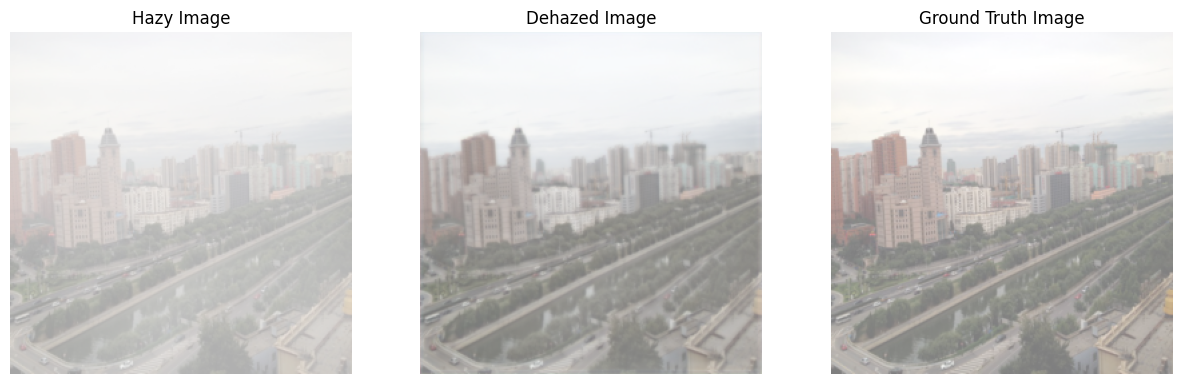

In [6]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define helper functions (e.g., for data loading and preprocessing)
class HazyDataset(Dataset):
    def __init__(self, hazy_dir, gt_dir, transform=None):
        self.hazy_dir = hazy_dir
        self.gt_dir = gt_dir
        self.transform = transform

        # Get list of hazy and ground truth images
        self.hazy_images = sorted(os.listdir(hazy_dir))
        self.gt_images = sorted(os.listdir(gt_dir))
        
        # Create a list of all hazy images and their corresponding ground truth
        self.data = []
        for gt_img in self.gt_images:
            gt_base_name = os.path.splitext(gt_img)[0].replace('_GT', '')
            matching_hazy_imgs = [img for img in self.hazy_images if gt_base_name in img]
            for hazy_img in matching_hazy_imgs:
                self.data.append((hazy_img, gt_img))

        print(f"Found {len(self.hazy_images)} hazy images.")
        print(f"Found {len(self.gt_images)} ground truth images.")
        print(f"Total data pairs: {len(self.data)}")

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        hazy_img_name, gt_img_name = self.data[idx]

        hazy_image_path = os.path.join(self.hazy_dir, hazy_img_name)
        gt_image_path = os.path.join(self.gt_dir, gt_img_name)

        hazy_image = Image.open(hazy_image_path).convert('RGB')
        gt_image = Image.open(gt_image_path).convert('RGB')

        if self.transform:
            hazy_image = self.transform(hazy_image)
            gt_image = self.transform(gt_image)

        return hazy_image, gt_image

# Load the model
def load_model(model, model_path, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print("Loaded model.")

# Function to denormalize and display images
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Assuming the images are normalized between [-1, 1]
    return tensor.clamp(0, 1)

def show_images(hazy_image, output_image, gt_image):
    hazy_image = denormalize(hazy_image).cpu().numpy().transpose(1, 2, 0)
    output_image = denormalize(output_image).cpu().numpy().transpose(1, 2, 0)
    gt_image = denormalize(gt_image).cpu().numpy().transpose(1, 2, 0)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(hazy_image)
    axs[0].set_title("Hazy Image")
    axs[0].axis('off')

    axs[1].imshow(output_image)
    axs[1].set_title("Dehazed Image")
    axs[1].axis('off')

    axs[2].imshow(gt_image)
    axs[2].set_title("Ground Truth Image")
    axs[2].axis('off')

    plt.show()

# Define the default convolutional layer
def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size, padding=(kernel_size // 2), bias=bias)

# Define the pixel attention layer
class PALayer(nn.Module):
    def __init__(self, channel):
        super(PALayer, self).__init__()
        self.pa = nn.Sequential(
            nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // 8, 1, 1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.pa(x)
        return x * y

# Define the channel attention layer
class CALayer(nn.Module):
    def __init__(self, channel):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.ca = nn.Sequential(
            nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // 8, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.ca(y)
        return x * y

# Define the basic block
class Block(nn.Module):
    def __init__(self, conv, dim, kernel_size):
        super(Block, self).__init__()
        self.conv1 = conv(dim, dim, kernel_size, bias=True)
        self.act1 = nn.ReLU(inplace=True)
        self.conv2 = conv(dim, dim, kernel_size, bias=True)
        self.calayer = CALayer(dim)
        self.palayer = PALayer(dim)

    def forward(self, x):
        res = self.act1(self.conv1(x))
        res = res + x
        res = self.conv2(res)
        res = self.calayer(res)
        res = self.palayer(res)
        res = res + x
        return res

# Define the group of blocks
class Group(nn.Module):
    def __init__(self, conv, dim, kernel_size, blocks):
        super(Group, self).__init__()
        modules = [Block(conv, dim, kernel_size) for _ in range(blocks)]
        modules.append(conv(dim, dim, kernel_size))
        self.gp = nn.Sequential(*modules)

    def forward(self, x):
        res = self.gp(x)
        res = res + x
        return res

# Define the FFA network with additional convolutional layers
class FFA(nn.Module):
    def __init__(self, gps, blocks, conv=default_conv):
        super(FFA, self).__init__()
        self.gps = gps
        self.dim = 64
        kernel_size = 3
        pre_process = [
            conv(3, self.dim, kernel_size),
            nn.ReLU(inplace=True),
            conv(self.dim, self.dim, kernel_size),  # Added conv layer
            nn.ReLU(inplace=True),
            conv(self.dim, self.dim, kernel_size),  # Added conv layer
            nn.ReLU(inplace=True),
            conv(self.dim, self.dim, kernel_size)   # Added conv layer
        ]
        self.g1 = Group(conv, self.dim, kernel_size=kernel_size, blocks=blocks)
        self.g2 = Group(conv, self.dim, kernel_size=kernel_size, blocks=blocks)
        self.g3 = Group(conv, self.dim, kernel_size=kernel_size, blocks=blocks)
        self.ca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(self.dim * 3, self.dim // 16, 1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.dim // 16, self.dim * 3, 1, padding=0, bias=True),
            nn.Sigmoid()
        )
        self.palayer = PALayer(self.dim)

        post_process = [
            conv(self.dim, self.dim, kernel_size),
            conv(self.dim, 3, kernel_size)
        ]

        self.pre = nn.Sequential(*pre_process)
        self.post = nn.Sequential(*post_process)

    def forward(self, x1):
        x = self.pre(x1)
        res1 = self.g1(x)
        res2 = self.g2(res1)
        res3 = self.g3(res2)

        w = self.ca(torch.cat([res1, res2, res3], dim=1))
        w = w.view(-1, self.dim, 3, 1, 1)
        out = (w[:, :, 0, :, :] * res1) + (w[:, :, 1, :, :] * res2) + (w[:, :, 2, :, :] * res3)
        out = self.palayer(out)
        x = self.palayer(out)
        x = self.post(out)
        return x + x1

if __name__ == "__main__":
    # Paths
    dataset_path = '/kaggle/input/reside/RESIDE'  # Ensure this path points to the dataset in Kaggle environment
    hazy_dir = os.path.join(dataset_path, 'hazy')
    gt_dir = os.path.join(dataset_path, 'clear')

    # Load model
    model_path = '/kaggle/working/best_ssim_model.pth'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FFA(gps=3, blocks=19)  # Make sure to use the same model architecture
    load_model(model, model_path, device)

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize images to 256x256
        transforms.ToTensor(),
    ])

    # Load a few test images
    test_dataset = HazyDataset(hazy_dir=hazy_dir, gt_dir=gt_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    # Test the model
    with torch.no_grad():
        for hazy_images, gt_images in test_loader:
            hazy_images, gt_images = hazy_images.to(device), gt_images.to(device)
            
            outputs = model(hazy_images)
            
            # Display the images
            show_images(hazy_images[0], outputs[0], gt_images[0])
            break  # Just show one example, remove break to show more examples
